In [41]:
%reset

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

# Exercise 1

## A: Power Reflection

In [2]:
N = 32
n1 = 3.5
n2 = 3.1
ld = 900         # nm

L1 = 64.3           # nm
L2 = 77.6           # nm

xlim0 = 800         # nm
xlim1 = 1000        # nm

In [11]:
L2 = ld/(4*n2)
L2

72.58064516129032

In [12]:
# Power reflection
st = 1                                      # nm
lambdas = np.arange(xlim0, xlim1+st, st)    # nm

Rtot = []
Ttot = []
for l in lambdas:
    k0 = 2*np.pi/l
    T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
    TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0], [0, np.exp(-1j*n*k0*L)]])

    # build the unit transfer matrix
    Tunit = (np.matmul(np.matmul(np.matmul(TL(L2, n2), T(n1, n2)), TL(L1, n1)), T(n2, n1)))

    Tt = np.identity(len(Tunit))
    for i in range(N):
        Tt = np.matmul(Tt, Tunit)

    Rtot.append(np.abs(np.divide(Tt[0][1], Tt[1][1]))**2)
    Ttot.append(np.absolute(Tt[0][0] - np.divide((Tt[0][1] * Tt[1][0]), Tt[1][1]))**2)

Rtot = np.array(Rtot)
Ttot = np.array(Ttot)

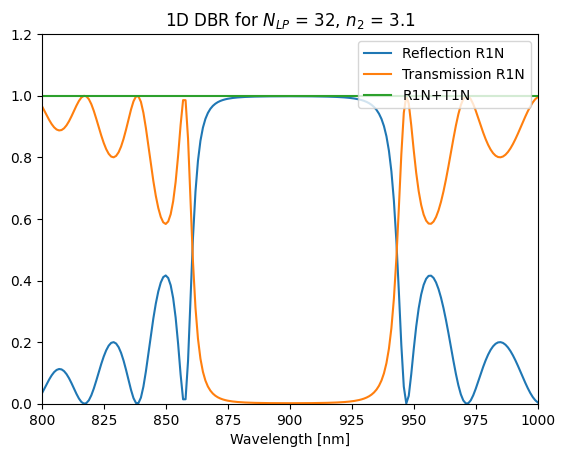

In [13]:
plt.figure()
plt.plot(lambdas, Rtot, label="Reflection R1N")
plt.plot(lambdas, Ttot, label="Transmission R1N")
plt.plot(lambdas, Rtot + Ttot, label="R1N+T1N")
plt.xlabel("Wavelength [nm]")
plt.xlim([xlim0, xlim1])
plt.ylim([0, 1.2])
plt.title("1D DBR for $N_{LP}$ = " + str(N) + ", $n_2$ = " + str(n2))
plt.legend(loc='upper right')
plt.show()

## B: Field profile for a DBR

In [44]:
n1 = 3.5
n2 = 2.9

N = 8

lda = 900             # nm
k0 = 2*np.pi/lda

L1 = 900/(4*n1)
L2 = 900/(4*n2)

AN = np.array([1, 0]).reshape([2,1])

zlim0 = 0           # nm
zlim1 = (L1+L2)*N   # nm

st = 1                                  # nm
zr = np.arange(0, zlim1, st)         # nm

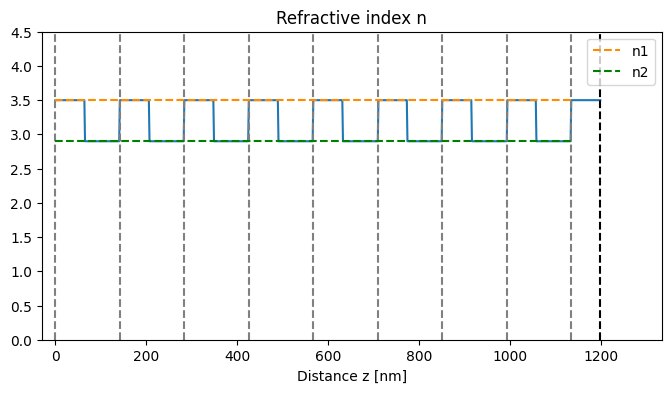

In [85]:
x = [i for i in np.arange(0, N*(L1+L2)+L1, (L1+L2)/100)]
y = [n1 if i % (L1+L2) < L1 else n2 for i in np.arange(0, N*(L1+L2)+L1, (L1+L2)/100)]

plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.axvline(x=max(zr)+L1, color="black", linestyle="--")
for hh in np.arange(0, max(zr)+L1, L1+L2):
    plt.axvline(x=hh, color="gray", linestyle="--")
plt.hlines(y=n1, xmin=min(zr), xmax=max(zr), color="darkorange", linestyle="--", label="n1")
plt.hlines(y=n2, xmin=min(zr), xmax=max(zr), color="green", linestyle="--", label="n2")
plt.xlim([0-30*st, max(zr)+200*st])
plt.xlabel("Distance z [nm]")
plt.xticks(np.arange(0, max(zr)+200, 200))
plt.ylim([0, 4.5])
plt.title("Refractive index n")
plt.legend()
plt.show()

~~  T_t =  T_{L1} * T_{21} * (T_{L2} * T_{12} * T_{L1} * T_{21})^N = T_{L1} * T_{21} * (T_{unit})^N  ~~

$ T_t =  (T_{12} * T_{L1} * T_{21} * T_{L2})^N * T_{12} * T_{L1} = (T_{unit})^N  * T_{12} * T_{L1} $

In [35]:
T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0], [0, np.exp(-1j*n*k0*L)]])
# build the unit transfer matrix
Tt = np.identity(2)
Tunit = (np.matmul(np.matmul(np.matmul(TL(L2, n2), T(n1, n2)), TL(L1, n1)), T(n2, n1)))
for i in range(N):
    Tt = np.matmul(Tt, Tunit)
Tt = np.matmul(Tt, np.matmul(TL(L1, n1), T(n2, n1)))
Tts = sparse.csr_matrix(Tt)
Ttinv = np.linalg.pinv(Tts.toarray())

A10 = np.matmul(Ttinv, AN)
np.abs(A10[0][0] + A10[1][0])

4.501532309439192

In [13]:
# Find the field at z=0

Ttot = np.identity(2)
Ttot = np.matmul(Ttot, TL(L1, n1, k0))
Ttot = np.matmul(Ttot, T(n2, n1))
for i in range(N):
    Ttot = np.matmul(Ttot, TL(L2, n2, k0))
    Ttot = np.matmul(Ttot, T(n1, n2))
    Ttot = np.matmul(Ttot, TL(L1, n1, k0))
    Ttot = np.matmul(Ttot, T(n2, n1))

Tts = sparse.csr_matrix(Ttot)
Ttinv = np.linalg.pinv(Tts.toarray())

A10 = np.matmul(Ttinv, AN)

In [14]:
np.abs(A10[0][0] + A10[1][0])

1.0290666827803867

$
T_t = 
     \begin{cases}
       T_{1}(z_{lr}-L_1) &\quad z < L_1\\
       T_{2}(z_{lr}-L_2) * (T_{12} * T_{L1} * T_{21} * T_{L2})^{N} * T_{12} * T_{L1} &\quad z > L_1\quad \&\quad z_{lr} < L_2 \\ 
       T_{1}(z_{lr}-L_1) * T_{21} * T_{L2} * (T_{12} * T_{L1} * T_{21} * T_{L2})^{N} * T_{12} * T_{L1} &\quad z > L_1\quad \&\quad z_{lr} > L_2 \\ 
     \end{cases}
$

with $N = (z-L_1)/(L_1+L_2), \, N\in\mathbb{N}$ and $z_{lr} =\!\!\mod{(z-L_1, L_1+L_2)}$

In [36]:
Etot = []

Tunit = (np.matmul(np.matmul(np.matmul(TL(L2, n2), T(n1, n2)), TL(L1, n1)), T(n2, n1)))

for z in zr:
    # build the transfer matrix

    # we start from unity
    Tt = np.identity(2)

    lz_r = z % (L1 + L2)            # remained distance from integer interval
    n = int((z-L1)/(L1+L2))         # number of integer layers in between first and last part

    if z < L1:
        Tt = np.matmul(Tt, TL(lz_r-L1, n1))
    else:       # z >= L1
        Tt = np.matmul(Tt, TL(L1, n1))
        Tt = np.matmul(Tt, T(n1, n2))
        for i in range(n):
            Tt = np.matmul(Tt, Tunit)
        if lz_r < L2:
            Tt = np.matmul(Tt, TL(lz_r-L2, n2))
        else:
            Tt = np.matmul(Tt, TL(L2, n2))
            Tt = np.matmul(Tt, T(n2, n1))
            Tt = np.matmul(Tt, TL(lz_r-L1, n1))

    A1z = np.matmul(Tt, A10)
    Etot.append(np.abs(A1z[0][0] + A1z[1][0]))
    
Etot = np.array(Etot)

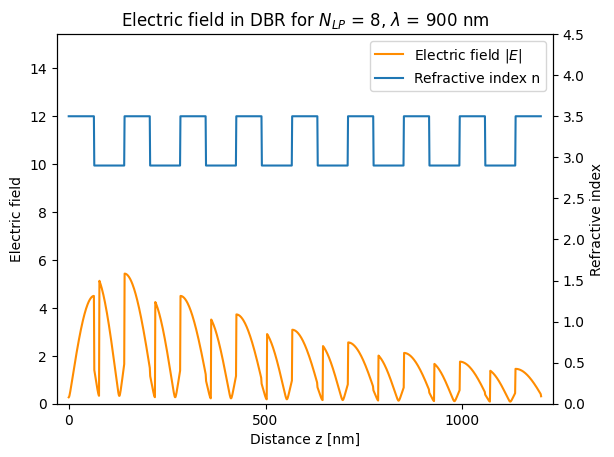

In [37]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(zr, Etot, color="darkorange", label=r"Electric field $|E|$")
lns2 = ax2.plot(np.linspace(0, zlim1, len(nidxt)), np.array(nidxt), label="Refractive index n")

ax1.set_xlabel("Distance z [nm]")
ax1.set_ylabel("Electric field")
ax2.set_ylabel("Refractive index")

plt.xticks(np.arange(0, max(zr), 500))
plt.xlim([0-30*st, max(zr)+30*st])
ax1.set_ylim([0, max(Etot)+10])
ax2.set_ylim([0, 4.5])

plt.title("Electric field in DBR for $N_{LP}$ = " + str(N) + ", $\lambda$ = " + str(lda) + " nm")

# build legend
lns = lns1+lns2
labs = [ln.get_label() for ln in lns]
ax1.legend(lns, labs, loc='upper right')

plt.show()

# Exercise 2

In [ ]:
## A: Power Reflection
N = 16
n1 = 3.5
n2 = 2.9
ld = 900         # nm

L1 = 64.3           # nm
L2 = 77.6           # nm

xlim0 = 800         # nm
xlim1 = 1000        # nm
L2 = ld/(4*n2)
L2
# Power reflection
st = 1                                      # nm
lambdas = np.arange(xlim0, xlim1+st, st)    # nm

Rtot = []
Ttot = []
for l in lambdas:
    k0 = 2*np.pi/l
    T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
    TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0], [0, np.exp(-1j*n*k0*L)]])

    # build the unit transfer matrix
    Tunit = (np.matmul(np.matmul(np.matmul(TL(L2, n2), T(n1, n2)), TL(L1, n1)), T(n2, n1)))

    Tt = np.identity(len(Tunit))
    for i in range(N):
        Tt = np.matmul(Tt, Tunit)

    Rtot.append(np.abs(np.divide(Tt[0][1], Tt[1][1]))**2)
    Ttot.append(np.absolute(Tt[0][0] - np.divide((Tt[0][1] * Tt[1][0]), Tt[1][1]))**2)

Rtot = np.array(Rtot)
Ttot = np.array(Ttot)
plt.figure()
plt.plot(lambdas, Rtot, label="Reflection R1N")
plt.plot(lambdas, Ttot, label="Transmission R1N")
plt.plot(lambdas, Rtot + Ttot, label="R1N+T1N")
plt.xlabel("Wavelength [nm]")
plt.xlim([xlim0, xlim1])
plt.ylim([0, 1.2])
plt.title("1D DBR for $N_{LP}$ = " + str(N) + ", $n_2$ = " + str(n2))
plt.legend(loc='upper right')
plt.show()